# Details about the data:

399 neurons are being recorded, 98 trials of mice watching a movie where each signal is about 80 seconds. 

The neurons each has a number associated with them, ranging from 0-399. Region names are in key.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as la
import tarfile


In [3]:
# Extract Tar Ball
tar = tarfile.open("data.tar.gz", "r:gz")
tar.extractall()
tar.close()

In [2]:
# Load Data
Dat = np.load('data.npy')
Keys = pd.read_csv('key.csv')
Region = Keys['ccf']    # Index corresponds with Neuron Number

In [7]:
neurons_num = np.shape(Dat)[0]
trials_num = np.shape(Dat)[1]
signal_len = np.shape(Dat)[2]
time = np.linspace(0, 80, signal_len)

print('Data Dimensions are: {} x {} x {}'.format(neurons_num, trials_num, signal_len))

Data Dimensions are: 399 x 98 x 2430


In [8]:
# Count how many unique regions there are
regcount = {}
for r in Region:
    if r in regcount:
        regcount[r] = regcount[r] + 1
    else:
        regcount[r] = 0

print('We have ' + str(len(regcount)) + ' unique regions')

We have 8 unique regions


In [9]:
# Check for NaN entries
if np.any(np.isnan(Dat)):
    print('Contains NaN entrie(s)')

Contains NaN entrie(s)


In [27]:
# Locate where NaN entries exist - we see that every 29th trial contains NaN values
nan_where = {}
for i in np.arange(neurons_num):
    for j in np.arange(trials_num):
        if np.any(np.isnan(Dat[i][j])):
            if i in nan_where.keys():
                nan_where[i].append(j+1)
            else:
                nan_where[i] = [j+1]

In [28]:
# Remove 29th trial from every neuron
beg = np.arange(0, 28)
en = np.arange(29, trials_num)

trials = np.concatenate((beg, en))
dat2 = Dat[:, trials, :]
trials_num = trials_num - 1

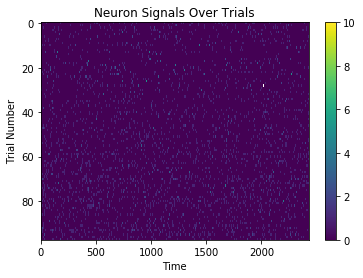

In [35]:
# Plot example of one neuron
signal = Dat[0][:]
plt.imshow(signal, aspect = 'auto')
plt.xlabel('Time')
plt.ylabel('Trial Number')
plt.title('Neuron Signals Over Trials')
plt.colorbar()

In [36]:
# Confirming that there are no more NaN values in our dataset 
if np.any(np.isnan(dat2)):
    print('Contains NaN entrie(s)')
else:
    print('Contains no NaN entrie(s)')

Contains no NaN entrie(s)


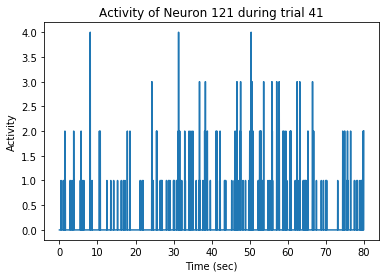

In [37]:
# Plot an example neuron activity signal 
neuron = 120
trial = 40
signal1 = dat2[neuron, trial, :]
plt.plot(time, signal1)
plt.title('Activity of Neuron ' + str(neuron + 1) + ' during trial ' + str(trial + 1))
plt.xlabel('Time (sec)')
plt.ylabel('Activity')
plt.savefig('actneu' + str(neuron+1) + 'tr' + str(trial+1) + '.png')
plt.show()

In [38]:
# Create a Signal Matrix where each signal is put into a column
signals_all = np.zeros([signal_len, trials_num*neurons_num])
k = 0
for n in np.arange(neurons_num):
    for m in np.arange(trials_num):
        signals_all[:, k] = dat2[n][m][:]
        k = k+1

In [39]:
# Mean center signal matrix
means = np.mean(signals_all, axis = 0)
signals_mcen = signals_all-means
signals_mcen = signals_mcen*(1/((np.shape(signals_mcen)[0]-1)))  

In [40]:
# apply SVD
u,s,vh = la.svd(signals_mcen, full_matrices=False)
v = np.transpose(vh)

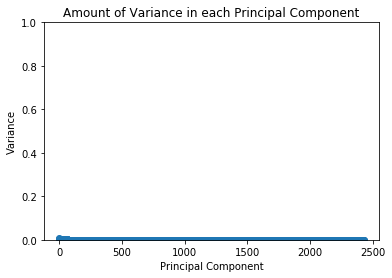

In [41]:
# Plot variance in PCs, we do not see a significant principal component in this case
plt.scatter(np.arange(len(s)), s**2/np.sum(s**2))
plt.ylim([0, 1])
plt.title('Amount of Variance in each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance')
plt.savefig('varsignals.png')

In [43]:
# Average the activity for all trials for each neuron
Activity_avg = np.zeros([neurons_num, signal_len])
for n in np.arange(neurons_num):
    aavg = np.zeros([1, signal_len])
    for m in np.arange(trials_num):
        aavg = aavg + dat2[n][m][:]
    aavg = (1/trials_num)*aavg
    Activity_avg[n] = aavg

# Mean Center
means = np.mean(Activity_avg, axis = 0)
signals_mcen = Activity_avg-means
signals_mcen = signals_mcen*(1/((np.shape(signals_mcen)[0]-1)))  

# apply SVD
u,s,vh = la.svd(signals_mcen, full_matrices=False)
v = np.transpose(vh)

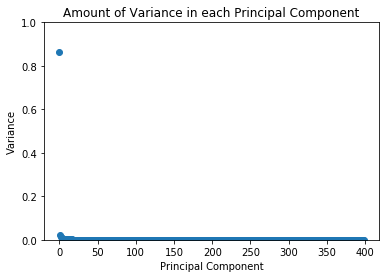

In [44]:
# Plot variance in PCs, we see more variance in this case
plt.scatter(np.arange(len(s)), s**2/np.sum(s**2))
plt.ylim([0, 1])
plt.title('Amount of Variance in each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance')
plt.savefig('avgvars.png')

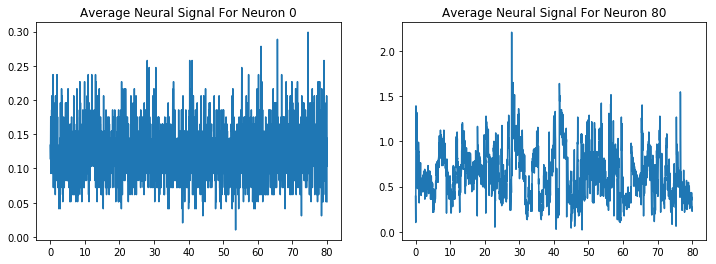

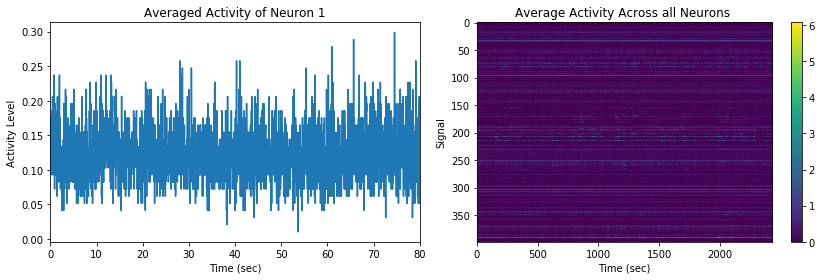

In [51]:
# Average activity for 0 and 80 are pretty different looking
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(time, Activity_avg[0])    
ax[0].set_title('Average Neural Signal For Neuron 0')
ax[1].plot(time, Activity_avg[80])    
ax[1].set_title('Average Neural Signal For Neuron 80')

# Create Spectrogram of Averaged signal 
width = 0.01
timeslide = np.arange(0,80, 0.1)
spc = np.zeros([len(timeslide), signal_len])
k = 0
n_num = 0
signal1 = Activity_avg[n_num]
for ts in timeslide:
    fil = np.exp(-width*(time-ts)**10)
    fs = signal1*fil
    fst = np.fft.fft(fs)
    spc[k,:] = np.abs(np.fft.fftshift(fst))
    k = k+1

x2 = np.arange(-signal_len/2, 0)
x1 = np.arange(0, signal_len/2)
kk = np.concatenate((x1, x2))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(time, signal1)
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('Activity Level')
ax[0].set_title('Averaged Activity of Neuron ' + str(n_num + 1))
ax[0].set_xlim([0, 80])
im = ax[1].imshow(Activity_avg, aspect='auto')
ax[1].set_title('Average Activity Across all Neurons ')
ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('Signal')
plt.tight_layout()
plt.colorbar(im, ax=ax[1])
plt.savefig('neuron' + str(n_num + 1) + 'fig.png')
plt.show()